In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time

from casacore.tables import table
import nifty_gridder as ng
import pprint

In [4]:
msname = "/home/vlad/data/EoR_sim/EoR0_5deg_12_pol.MS"
npixdirty   = 2048
degsize     = 2.0
nthreads    = 4 
epsilon     = 6e-6
DEG2RAD     = np.pi/180.

In [5]:
pp = pprint.PrettyPrinter()

In [6]:
t = table(msname, readonly=True)

RuntimeError: Table /home/vlad/data/EoR_sim/EoR0_5deg_12_pol.MS does not exist

In [185]:
uvw = t.getcol("UVW") # [:, uvw]

In [186]:
umax = np.amax(np.abs(uvw[:,0]))
vmax = np.amax(np.abs(uvw[:,1]))
uvmax = np.maximum(umax,vmax)
print("|UVmax| = ", uvmax)

|UVmax| =  64807.75


In [187]:
def uvw2d(u,v, nx):
    assert(len(u) == len(v))
    umax = np.amax(np.abs(u))
    vmax = np.amax(np.abs(v))
    uvmax = np.maximum(umax,vmax)
    nxuv = 1.1*2*uvmax
    uv2d = np.zeros((nx,nx))
    for i in range(len(u)):
        idu = int((u[i] + nxuv/2)/nxuv*nx)
        assert(idu < nx)
        idv = int((v[i] + nxuv/2)/nxuv*nx)
        assert(idv < nx)
        uv2d[idu, idv] = uv2d[idu, idv] + 1
    
    uv2d_list = []
    for i in range(nx):
        for j in range(nx):
            if uv2d[i,j] != 0:
                uv2d_list.append([i,j,uv2d[i,j]])
    uv2d_arr = np.asarray(uv2d_list)
    return uv2d_arr    

In [188]:
nx = 2048
uv2darr = uvw2d(uvw[:,0], uvw[:,1], nx)

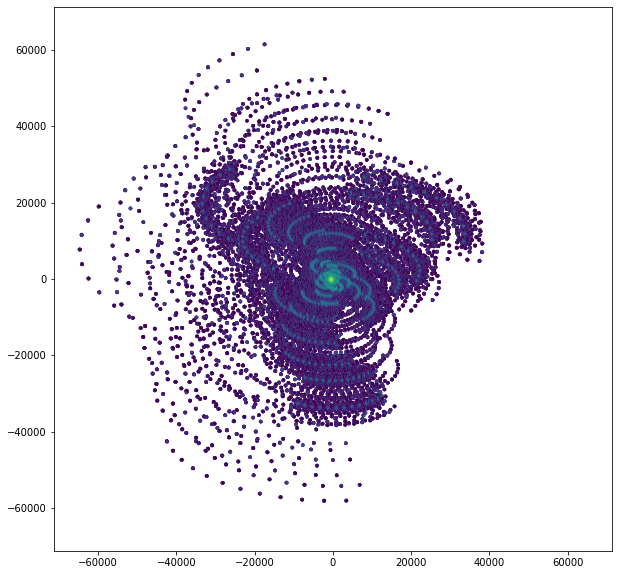

In [189]:
plt.rcParams['figure.figsize'] = 10, 10
plt.scatter((uv2darr[:,0]-nx/2)/nx*uvmax*2*1.1, (uv2darr[:,1]-nx/2)/nx*uvmax*2*1.1, c=np.log(uv2darr[:,2]), s=5)
plt.xlim([-uvmax*1.1, uvmax*1.1])
plt.ylim([-uvmax*1.1, uvmax*1.1])
plt.show()

In [190]:
#plt.rcParams['figure.figsize'] = 12, 12
#plt.scatter(uvw[:,0], uvw[:,1], s=5)
#plt.xlim([-uvmax*1.1, uvmax*1.1])
#plt.ylim([-uvmax*1.1, uvmax*1.1])
#plt.show()

In [191]:
pp.pprint(t[0])

{'ANTENNA1': 0,
 'ANTENNA2': 1,
 'ARRAY_ID': 0,
 'DATA': array([[-2.2112708 -5.60717940e-01j,  1.32834   +1.45562872e-01j,
         1.3283033 +1.45556003e-01j, -7.6996326 -1.17357826e+00j],
       [-2.025926  -7.91994095e-01j,  1.2238666 +2.58991271e-01j,
         1.2238331 +2.58981705e-01j, -7.096774  -1.89718604e+00j],
       [-2.143094  -6.93111777e-01j,  1.2954657 +2.12572172e-01j,
         1.2954298 +2.12563917e-01j, -7.513279  -1.59946024e+00j],
       [-2.0648284 -6.81835234e-01j,  1.2306247 +2.02881113e-01j,
         1.2305901 +2.02872932e-01j, -7.186596  -1.56483817e+00j],
       [-2.0233693 -7.08679318e-01j,  1.2191327 +2.24571183e-01j,
         1.2190983 +2.24562392e-01j, -7.1004634 -1.67928743e+00j],
       [-2.1238651 -6.33235931e-01j,  1.2701796 +1.78596869e-01j,
         1.2701445 +1.78589344e-01j, -7.4162683 -1.42874622e+00j],
       [-1.9266453 -6.33596361e-01j,  1.1607847 +1.80809379e-01j,
         1.1607527 +1.80801839e-01j, -6.7628183 -1.43549943e+00j],
       [-2.0

In [192]:
ms = np.array(t.getcol("DATA"), dtype=np.complex128) # [:, ch, corr]

In [193]:
print("ms.shape", ms.shape)

ms.shape (1569792, 160, 4)


In [194]:
print(uvw.shape)

(1569792, 3)


In [195]:
wgt = t.getcol("WEIGHT").astype("f8")

In [196]:
print(wgt.shape)

(1569792, 4)


In [197]:
# Flag if one correlation is flagged
flags = np.any(np.array(t.getcol("FLAG"),np.bool),axis=2) # [:, ch] - all frequency should be flagged out

In [198]:
print((t.getcol("FLAG")).shape, flags.shape)

(1569792, 160, 4) (1569792, 160)


In [199]:
print(set(t.getcol('FIELD_ID')), len(set(t.getcol('FIELD_ID'))), set(t.getcol('DATA_DESC_ID')), len(set(t.getcol('DATA_DESC_ID'))))
if len(set(t.getcol('FIELD_ID'))) != 1:
    raise RuntimeError
if len(set(t.getcol('DATA_DESC_ID'))) != 1:
    raise RuntimeError

{0} 1 {0} 1


In [200]:
t.close()

In [201]:
print('# Rows: {}'.format(ms.shape[0]))
print('# Channels: {}'.format(ms.shape[1]))
print('# Correlations: {}'.format(ms.shape[2]))
print("{} % flagged".format(np.sum(flags)/flags.size*100))

# Rows: 1569792
# Channels: 160
# Correlations: 4
0.0 % flagged


In [202]:
t = table(os.path.join(msname, 'SPECTRAL_WINDOW'), readonly=True)

Successful readonly open of default-locked table /home/vlad/data/EoR_sim/EoR0_5deg_12_pol.MS/SPECTRAL_WINDOW: 14 columns, 1 rows


In [203]:
#pp.pprint(t[0])

In [204]:
freq = t.getcol('CHAN_FREQ')[0]

In [205]:
print(freq)

[1.320e+08 1.321e+08 1.322e+08 1.323e+08 1.324e+08 1.325e+08 1.326e+08
 1.327e+08 1.328e+08 1.329e+08 1.330e+08 1.331e+08 1.332e+08 1.333e+08
 1.334e+08 1.335e+08 1.336e+08 1.337e+08 1.338e+08 1.339e+08 1.340e+08
 1.341e+08 1.342e+08 1.343e+08 1.344e+08 1.345e+08 1.346e+08 1.347e+08
 1.348e+08 1.349e+08 1.350e+08 1.351e+08 1.352e+08 1.353e+08 1.354e+08
 1.355e+08 1.356e+08 1.357e+08 1.358e+08 1.359e+08 1.360e+08 1.361e+08
 1.362e+08 1.363e+08 1.364e+08 1.365e+08 1.366e+08 1.367e+08 1.368e+08
 1.369e+08 1.370e+08 1.371e+08 1.372e+08 1.373e+08 1.374e+08 1.375e+08
 1.376e+08 1.377e+08 1.378e+08 1.379e+08 1.380e+08 1.381e+08 1.382e+08
 1.383e+08 1.384e+08 1.385e+08 1.386e+08 1.387e+08 1.388e+08 1.389e+08
 1.390e+08 1.391e+08 1.392e+08 1.393e+08 1.394e+08 1.395e+08 1.396e+08
 1.397e+08 1.398e+08 1.399e+08 1.400e+08 1.401e+08 1.402e+08 1.403e+08
 1.404e+08 1.405e+08 1.406e+08 1.407e+08 1.408e+08 1.409e+08 1.410e+08
 1.411e+08 1.412e+08 1.413e+08 1.414e+08 1.415e+08 1.416e+08 1.417e+08
 1.418

In [206]:
t.close()

In [207]:
t = table(os.path.join(msname, 'POLARIZATION'), readonly=True)

Successful readonly open of default-locked table /home/vlad/data/EoR_sim/EoR0_5deg_12_pol.MS/POLARIZATION: 4 columns, 1 rows


In [208]:
pp.pprint(t[0])

{'CORR_PRODUCT': array([[0, 0],
       [0, 1],
       [1, 0],
       [1, 1]], dtype=int32),
 'CORR_TYPE': array([ 9, 10, 11, 12], dtype=int32),
 'FLAG_ROW': False,
 'NUM_CORR': 4}


In [209]:
pol = list(t.getcol('CORR_TYPE')[0])

In [210]:
print("list(t.getcol('CORR_TYPE')[0]):", pol)

list(t.getcol('CORR_TYPE')[0]): [9, 10, 11, 12]


In [211]:
t.close()

In [212]:
# Use OSKAR-generated scalar MS with XX or RR data only
if len(pol) == 1:
    ind = [0]
# Use pollarized MS with [RR RL LR LL] or [XX XY YX YY]
else:
    if set(pol) <= set([5, 6, 7, 8]):
        ind = [pol.index(5), pol.index(8)]
    else:
        ind = [pol.index(9), pol.index(12)]
ms = np.sum(ms[:, :, ind], axis=2)
wgt = 1/np.sum(1/wgt, axis=1)

In [213]:
print(ind)

[0, 3]


In [214]:
print("New ms.shape:", ms.shape)

New ms.shape: (1569792, 160)


In [215]:
# WEIGHT -> WEIGHT_SPECTRUM
wgt = np.repeat(wgt[:, None], len(freq), axis=1)

In [216]:
print(wgt.shape)

(1569792, 160)


In [217]:
# FLAGGED -> WGT=0
wgt[flags] = 0

In [218]:
pixsize = degsize/npixdirty*DEG2RAD

In [219]:
do_wstacking=True
if epsilon > 5e-6:
    ms = ms.astype("c8")
    wgt = wgt.astype("f4")

In [220]:
print('Start gridding...')
t0 = time()
dirty = ng.ms2dirty(
    uvw, freq, ms, wgt, npixdirty, npixdirty, pixsize, pixsize, epsilon,
    do_wstacking=do_wstacking, nthreads=nthreads, verbosity=2)

Start gridding...


In [221]:
print('Done')
t = time() - t0
print("{} s".format(t))
print("{} visibilities/thread/s".format(np.sum(wgt != 0)/nthreads/t))

Done
76.6253182888031 s
819463.8717628068 visibilities/thread/s


In [222]:
dmin = np.amin(dirty)
dmax = np.amax(dirty)
print(dmin, dmax)

-3069939.8 241412130.0


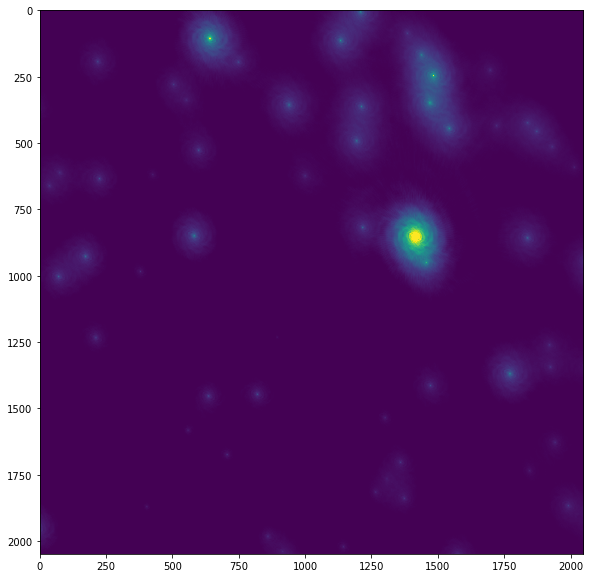

In [223]:
plt.imshow(dirty, vmin=0, vmax=dmax*0.3)
plot_name = msname.split('/')[-1].replace('.MS', '_nifty-dirty.jpg')
plt.savefig(plot_name)
plt.show()